In [1]:
from utils_activation import * 

### Filament Selection

In [2]:
url = 'http://apmonitor.com/pds/uploads/Main/manufacturing.txt'
data = pd.read_csv(url)

# 'material' (1 is abs, 0 is pla) with numpy.where
data['material'] = np.where(data['material']=='abs',1,0)

# 'infill pattern' (1 is 'grid', 0 is 'honeycomb') with list comprehension
data.infill_pattern = [1 if ip=="grid" else 0 for ip in data.infill_pattern]

X = data.drop(['material'], axis=1).to_numpy()
y = data['material'].to_numpy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

print(X.shape)

(70, 11)


In [3]:
tf.keras.backend.clear_session()

tf.random.set_seed(5)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05) 

num_input = 11
num_output = 2
num_trials = 20
num_hidden_all = [2]
alpha = 0.1

seed2= 10 

results_acc_filament = np.zeros((num_trials, 9, len(num_hidden_all)))
results_cov_filament = np.zeros((num_trials, 9, len(num_hidden_all)))
results_unc_filament = np.zeros((num_trials, 9, len(num_hidden_all)))
results_alphas_filament = np.zeros((2*num_trials, 3))


for idz, num_hidden in enumerate(num_hidden_all):
    for seed in range(num_trials):

        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed)
        # ELU 0, 1, 2
        model_fixed = build_model_identical(num_input, num_hidden, num_output, activation="elu", seed= seed2)
        model_fixed.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                              metrics=['accuracy'])
        
        model_trainable = build_model_identical(num_input, num_hidden, num_output, activation=CustomActivationELU(), seed= seed2)
        model_trainable.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])
        
        model_adaptable = build_model_different(num_input, num_hidden, num_output, bias=True, activation='ELU', seed= seed2)
        model_adaptable.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])
        
        # Train the models 
        history_fixed = model_fixed.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)
        history_trainable = model_trainable.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)
        history_adaptable = model_adaptable.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)

        # Evaluate the models 
        results_acc_filament[seed, 0, idz] = model_fixed.evaluate(X_test, y_test, verbose=0)[1]
        results_acc_filament[seed, 1, idz] = model_trainable.evaluate(X_test, y_test, verbose=0)[1]
        results_acc_filament[seed, 2, idz] = model_adaptable.evaluate(X_test, y_test, verbose=0)[1]

        results_cov_filament[seed, 0, idz], results_unc_filament[seed, 0, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_fixed, alpha)
        
        results_cov_filament[seed, 1, idz], results_unc_filament[seed, 1, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_trainable, alpha)
        
        results_cov_filament[seed, 2, idz], results_unc_filament[seed, 2, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_adaptable, alpha)
        
        # store alphas 
        results_alphas_filament[2*seed, 0] = model_adaptable.layers[1].get_weights()[2][0]

        results_alphas_filament[2*seed+1 , 0] = model_adaptable.layers[2].get_weights()[2][0]
        
        
        # Softplus 3, 4, 5
        model_fixed = build_model_identical(num_input, num_hidden, num_output, activation="softplus", seed= seed2)
        model_fixed.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                              metrics=['accuracy'])
        
        model_trainable = build_model_identical(num_input, num_hidden, num_output, activation=CustomActivationSoftPlus(), seed= seed2)
        model_trainable.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])
        
        model_adaptable = build_model_different(num_input, num_hidden, num_output, bias=True, activation='Softplus', seed= seed2)
        model_adaptable.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

        
        # Train the models 
        history_fixed = model_fixed.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)
        history_trainable = model_trainable.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)
        history_adaptable = model_adaptable.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)

        # Evaluate the models 
        results_acc_filament[seed, 3, idz] = model_fixed.evaluate(X_test, y_test, verbose=0)[1]
        results_acc_filament[seed, 4, idz] = model_trainable.evaluate(X_test, y_test, verbose=0)[1]
        results_acc_filament[seed, 5, idz] = model_adaptable.evaluate(X_test, y_test, verbose=0)[1]


        results_cov_filament[seed, 3, idz], results_unc_filament[seed, 3, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_fixed, alpha)
        
        results_cov_filament[seed, 4, idz], results_unc_filament[seed, 4, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_trainable, alpha)
        
        results_cov_filament[seed, 5, idz], results_unc_filament[seed, 5, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_adaptable, alpha)

        
        # store alphas 
        results_alphas_filament[2*seed, 1] = model_adaptable.layers[1].get_weights()[2][0]

        results_alphas_filament[2*seed+1 , 1] = model_adaptable.layers[2].get_weights()[2][0]

        # Swish 6, 7, 8
        model_fixed = build_model_identical(num_input, num_hidden, num_output, activation="swish", seed= seed2)
        model_fixed.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                              metrics=['accuracy'])
        
        model_trainable = build_model_identical(num_input, num_hidden, num_output, activation=CustomActivationSwish(), seed= seed2)
        model_trainable.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])
        
        model_adaptable = build_model_different(num_input, num_hidden, num_output, bias=True, activation='Swish', seed= seed2)
        model_adaptable.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])
        
        
        # Train the models 
        history_fixed = model_fixed.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)
        history_trainable = model_trainable.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)
        history_adaptable = model_adaptable.fit(X_train, y_train, epochs=100, batch_size=len(X_train), verbose=0)

        # Evaluate the models 
        results_acc_filament[seed, 6, idz] = model_fixed.evaluate(X_test, y_test, verbose=0)[1]
        results_acc_filament[seed, 7, idz] = model_trainable.evaluate(X_test, y_test, verbose=0)[1]
        results_acc_filament[seed, 8, idz] = model_adaptable.evaluate(X_test, y_test, verbose=0)[1]

        results_cov_filament[seed, 6, idz], results_unc_filament[seed, 6, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_fixed, alpha)
        
        results_cov_filament[seed, 7, idz], results_unc_filament[seed, 7, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_trainable, alpha)
        
        results_cov_filament[seed, 8, idz], results_unc_filament[seed, 8, idz] = find_cov_unc(X_train, y_train, X_test, 
                                                                                              y_test, model_adaptable, alpha)
        
        # store alphas 
        results_alphas_filament[2*seed, 2] = model_adaptable.layers[1].get_weights()[2][0]

        results_alphas_filament[2*seed+1 , 2] = model_adaptable.layers[2].get_weights()[2][0]


1/1 [==============================] - 0s 0s/step


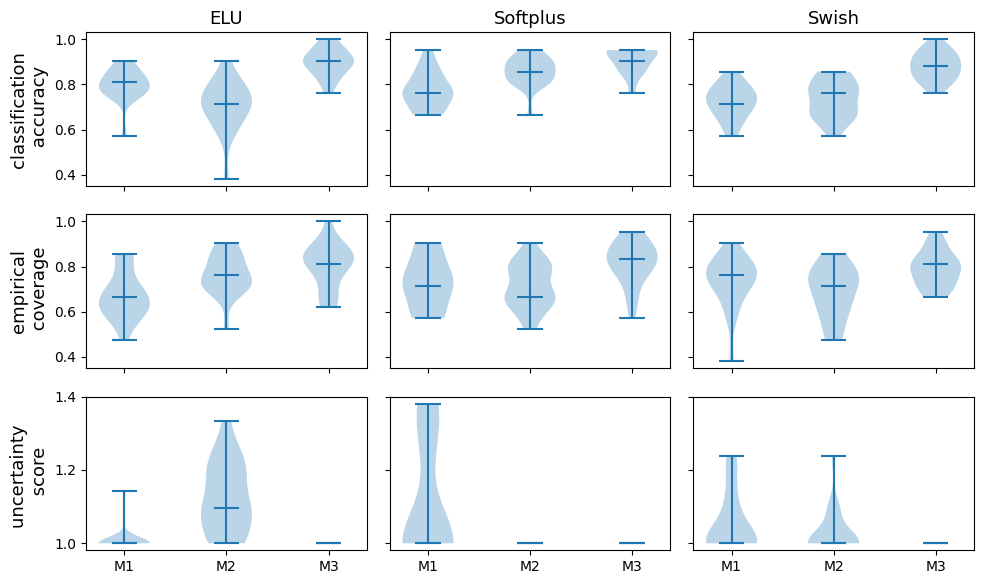

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with three subplots in one row
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey='row', sharex='col')
plt.rcParams["font.size"] = 12
labels = ["M1", "M2", "M3"]

# Plot the violin plots in each subplot
idz = 0
axes[0,0].violinplot([results_acc_filament[:,0,idz], 
                    results_acc_filament[:,1,idz], 
                    results_acc_filament[:,2,idz]], showmedians=True)
axes[0,0].set_xticks([1,2,3])
axes[0,0].set_xticklabels(labels)
axes[0,0].set_ylabel('classification\n accuracy', fontsize=13)

axes[0,1].violinplot([results_acc_filament[:,3,idz], 
                    results_acc_filament[:,4,idz], 
                    results_acc_filament[:,5,idz]], showmedians=True)
axes[0,1].set_xticks([1,2,3])
axes[0,1].set_xticklabels(labels)

axes[0,2].violinplot([results_acc_filament[:,6,idz], 
                    results_acc_filament[:,7,idz], 
                    results_acc_filament[:,8,idz]], showmedians=True)
axes[0,2].set_xticks([1,2,3])
axes[0,2].set_xticklabels(labels)

# Set titles for each subplot
axes[0,0].set_title('ELU',  fontsize=13)
axes[0,1].set_title('Softplus',  fontsize=13)
axes[0,2].set_title('Swish',  fontsize=13)


# Next (cov)
axes[1,0].violinplot([results_cov_filament[:,0,idz], 
                    results_cov_filament[:,1,idz], 
                    results_cov_filament[:,2,idz]], showmedians=True)
axes[1,0].set_xticks([1,2,3])
axes[1,0].set_xticklabels(labels)
axes[1,0].set_ylabel('empirical\n coverage', fontsize=13)

axes[1,1].violinplot([results_cov_filament[:,3,idz], 
                    results_cov_filament[:,4,idz], 
                    results_cov_filament[:,5,idz]], showmedians=True)
axes[1,1].set_xticks([1,2,3])
axes[1,1].set_xticklabels(labels)

axes[1,2].violinplot([results_cov_filament[:,6,idz], 
                    results_cov_filament[:,7,idz], 
                    results_cov_filament[:,8,idz]], showmedians=True)
axes[1,2].set_xticks([1,2,3])
axes[1,2].set_xticklabels(labels)

# Next (unc)
axes[2,0].violinplot([results_unc_filament[:,0,idz], 
                    results_unc_filament[:,1,idz], 
                    results_unc_filament[:,2,idz]], showmedians=True)
axes[2,0].set_xticks([1,2,3])
axes[2,0].set_xticklabels(labels)
axes[2,0].set_ylabel('uncertainty \n score', fontsize=13)

axes[2,1].violinplot([results_unc_filament[:,3,idz], 
                    results_unc_filament[:,4,idz], 
                    results_unc_filament[:,5,idz]], showmedians=True)
axes[2,1].set_xticks([1,2,3])
axes[2,1].set_xticklabels(labels)

axes[2,2].violinplot([results_unc_filament[:,6,idz], 
                    results_unc_filament[:,7,idz], 
                    results_unc_filament[:,8,idz]], showmedians=True)
axes[2,2].set_xticks([1,2,3])
axes[2,2].set_xticklabels(labels)



# Adjust spacing between subplots
plt.tight_layout()


# Show the figure
plt.show()
